Side Note: 'Changes in tonic LC activity induced by handgrip affects phasic responses to salient stimuli in the period immediately afterwards (using pupil dilation used to infer LC responses).'

# Obtain data from files
Import Basic Libraries and EegTF module.

In [1]:
import EegTF
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline
import keras

import seaborn as sns
sns.set_palette('muted') 
sns.set_style('darkgrid') 

Save EEG file names in current directory

In [2]:
ls /Users/isaacmenchaca/Desktop/reanalysis/EEG_DATA_HOLD_Epoch_matfiles/*.mat > hold.txt

In [3]:
ls /Users/isaacmenchaca/Desktop/reanalysis/EEG_DATA_SQUEEZE_Epoch_matfiles/*.mat > squeeze.txt

Extract file names from .txt files.

In [4]:
with open('hold.txt', 'r') as f: 
    x = f.readlines()
    holdFiles = []
    for file in x:
        holdFiles.append(file.replace('\n', ''))

with open('squeeze.txt', 'r') as f: 
    x = f.readlines()
    squeezeFiles = []
    for file in x:
        squeezeFiles.append(file.replace('\n', ''))

Remove the .txt files (not necessary unless you want to re-run entire notebook again in future)

In [5]:
rm hold.txt

In [6]:
rm squeeze.txt

Extracting the total number of files along with how many epochs there are per certain condition.

In [7]:
sumHoldTrials = 0
sumSqueezeTrials = 0 

for file in holdFiles:
    data = scipy.io.loadmat(file)
    sumHoldTrials += data["EEG"][0][0]["trials"][0][0]
    
for file in squeezeFiles:
    data = scipy.io.loadmat(file)
    sumSqueezeTrials += data["EEG"][0][0]["trials"][0][0]

Testing stft4EegChannel functionality, also useful to determine shape of data by having f (frequency) and t (time). To understand how stft4EegChannel works, I suggest looking at https://isaacmenchaca.github.io/2020/02/07/EegTF.html.

In [8]:
# 103 trials total
f, t, Zxx = EegTF.stft4EegChannel(fileName = file, channel = 'Cz', 
                timeStep = 10,  startTime = -1500, endTime = 3500, windowSize = 1000, 
                desiredStartTime = -1000, desiredEndTime = 3000,
                trial_epoch =1,
                frequencyStop = 40, 
                windowTaper = 'hann', plot_data=None)

# Perform STFT TF Decomp., Adjust Data into Matrices, and Create Identity Labels
Setting up and concatenating data per condition (hold and squeeze).

In [9]:
x_TF_hold = np.zeros([sumHoldTrials, len(f), len(t), 1])
x_TF_squeeze = np.zeros([sumSqueezeTrials, len(f), len(t), 1])

totalHoldTrials = 0
for fileindex, file in enumerate(holdFiles):
    data = scipy.io.loadmat(file)
    EEGtrials = data["EEG"][0][0]["trials"][0][0]
    for epoch in range(EEGtrials):
        f, t, Zxx = EegTF.stft4EegChannel(fileName = file, channel = 'Cz', 
                timeStep = 10,  startTime = -1500, endTime = 3500, windowSize = 1000, 
                desiredStartTime = -1000, desiredEndTime = 3000,
                trial_epoch = epoch + 1,
                frequencyStop = 40, 
                windowTaper = 'hann', plot_data=None)
        
        x_TF_hold[totalHoldTrials, :, :] = Zxx.reshape([81, 202, 1])
        totalHoldTrials += 1
    
    
totalSqueezeTrials = 0
for fileindex, file in enumerate(squeezeFiles):
    data = scipy.io.loadmat(file)
    EEGtrials = data["EEG"][0][0]["trials"][0][0]
    for epoch in range(EEGtrials):
        f, t, Zxx = EegTF.stft4EegChannel(fileName = file, channel = 'Cz', 
                timeStep = 10,  startTime = -1500, endTime = 3500, windowSize = 1000, 
                desiredStartTime = -1000, desiredEndTime = 3000,
                trial_epoch = epoch + 1,
                frequencyStop = 40, 
                windowTaper = 'hann', plot_data=None)
        
        x_TF_squeeze[totalSqueezeTrials, :, :] = Zxx.reshape([81, 202, 1])
        totalSqueezeTrials += 1


Data quality check. Observe if the tf data is properly adjusted into the matrices. Example in x_TF_hold.

[[ 1.00837827  1.01664519  1.0242672  ...  1.21540642  1.21476042
   1.21266937]
 [ 0.96937668  0.9755494   0.98069668 ...  1.26268351  1.252689
   1.24198902]
 [ 0.88855088  0.89161873  0.89389122 ...  1.22902763  1.21336627
   1.19699228]
 ...
 [-0.64088261 -0.63599622 -0.63207549 ... -0.74929386 -0.74908513
  -0.7490347 ]
 [-0.58144253 -0.57178557 -0.56306612 ... -0.73317277 -0.73265374
  -0.73273206]
 [-0.6119619  -0.60087234 -0.59039205 ... -0.73365557 -0.72697687
  -0.7212345 ]]


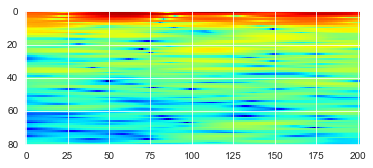

In [10]:
print(x_TF_hold[0, :, :, 0])
plt.figure()
plt.imshow(x_TF_hold[0, :, :, 0], cmap=plt.cm.jet)
plt.show()

Observe shape of TF matrices.

* 103 total epoch trials for hold.
* 115 total epoch trials for squeeze.
* BOTH: 
    * 81 different frequency values up to 40 Hz.
    * 202 different time steps: -1000 to 3000 ms.
    * 1 value for power.

In [11]:
print('Shape of hold TF data:', x_TF_hold.shape)
print('Shape of squeeze TF data:', x_TF_squeeze.shape)

Shape of hold TF data: (103, 81, 202, 1)
Shape of squeeze TF data: (115, 81, 202, 1)


hold is labeled as 0, squeeze is labeled as 1.

In [12]:
label_hold = np.zeros((x_TF_hold[:, 0, 0, 0]).shape)
label_squeeze = np.ones((x_TF_squeeze[:, 0, 0, 0]).shape)
print('Hold Label Shape:',label_hold.shape)
print('Squeeze Label Shape:', label_squeeze.shape)

Hold Label Shape: (103,)
Squeeze Label Shape: (115,)


Concatenate x_TF_hold, x_TF_squeeze into a single variable. There should be a total of hold + squeeze epoch trial instances.

In [13]:
concatenated_data = np.concatenate((x_TF_hold, x_TF_squeeze), axis=0)
concatenated_data.shape

(218, 81, 202, 1)

Concatenate x_TF_hold, x_TF_squeeze identity labels into a single variable. There should be a total of hold + squeeze epoch trial instances.

In [14]:
concatenated_labels = np.concatenate((label_hold, label_squeeze), axis=0)
concatenated_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Create Shuffled Train and Test Data. Build Deep Learning Model.

use sklearn to randomly split train and test data.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(concatenated_data, 
                                                    concatenated_labels, 
                                                    test_size=0.20, 
                                                    random_state=0)

In [16]:
print('Samples in Train data shape:', X_train.shape[0])
print('Samples in Test data shape:', X_test.shape[0])

Samples in Train data shape: 174
Samples in Test data shape: 44


Import Keras, high-level API for tensorflow

In [17]:
import keras
from keras import Sequential
from keras.layers import Dense, Conv1D, Conv2D, Flatten, MaxPool2D, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization

Build model

In [85]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', padding = 'same', 
                 input_shape = X_train.shape[1:]))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'valid'))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer = opt, 
             loss = 'binary_crossentropy',
             metrics = 'accuracy')
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 81, 202, 16)       80        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 40, 101, 16)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 64640)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 64641     
Total params: 64,721
Trainable params: 64,721
Non-trainable params: 0
_________________________________________________________________
None


Visualize Model

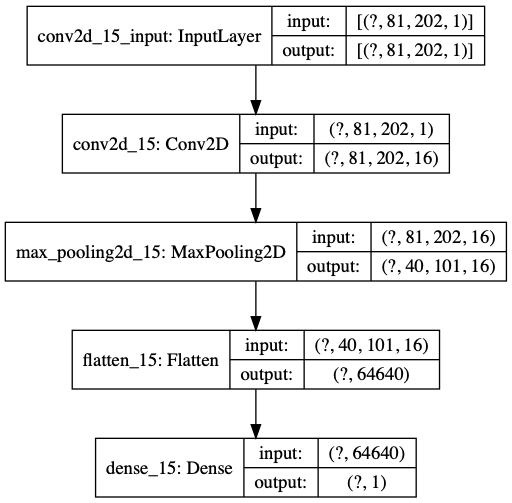

In [86]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train Model

Callbacks:
* Enable early stopping.
* ModelCheckPoint

Model will obtain weights from best val accur.

In [87]:
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_loss')
model_save = ModelCheckpoint('best_model.hdf5', save_best_only=True)
model_training = model.fit(X_train, Y_train, validation_split= 0.3, epochs = 50,
                          callbacks= [model_save],
                          batch_size = 3)

Epoch 1/50
41/41 [==============================] - 0s 9ms/step - loss: 0.7094 - accuracy: 0.4876 - val_loss: 0.8041 - val_accuracy: 0.4340
Epoch 2/50
41/41 [==============================] - 0s 6ms/step - loss: 0.6737 - accuracy: 0.5620 - val_loss: 0.7366 - val_accuracy: 0.4340
Epoch 3/50
41/41 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6612 - val_loss: 0.6958 - val_accuracy: 0.5660
Epoch 4/50
41/41 [==============================] - 0s 6ms/step - loss: 0.5841 - accuracy: 0.8430 - val_loss: 0.7259 - val_accuracy: 0.4717
Epoch 5/50
41/41 [==============================] - 0s 6ms/step - loss: 0.5476 - accuracy: 0.8430 - val_loss: 0.6930 - val_accuracy: 0.5094
Epoch 6/50
41/41 [==============================] - 0s 6ms/step - loss: 0.5276 - accuracy: 0.8512 - val_loss: 0.7021 - val_accuracy: 0.5660
Epoch 7/50
41/41 [==============================] - 0s 6ms/step - loss: 0.4835 - accuracy: 0.9174 - val_loss: 0.7162 - val_accuracy: 0.5660
Epoch 8/50
41/41 [==

# Evaluate Model

Observe loss and accuracy plots for train and validation data.

Awful, look up new strategies / approaches to improve model.

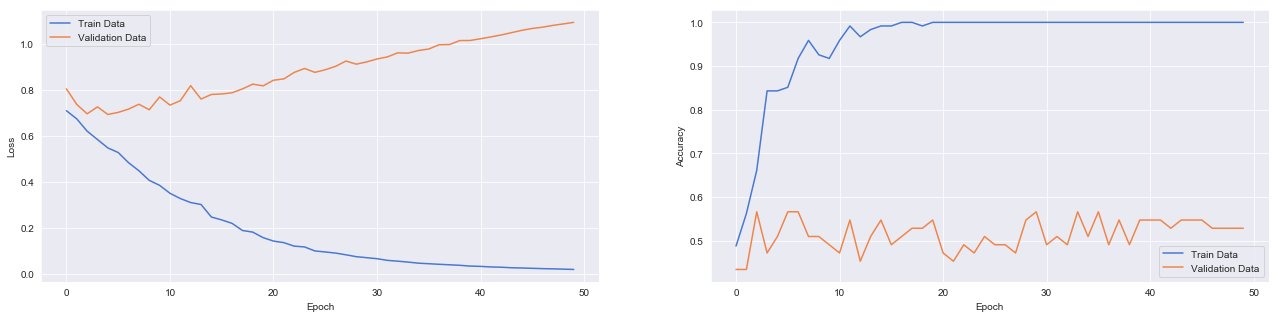

In [88]:
plt.figure(figsize=(22, 5))
plt.subplot(1, 2, 1)
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Validation Data'])


plt.subplot(1, 2, 2)
plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Validation Data'])


plt.show()

Obtain predictions and accuracy on Test data.

In [89]:
model.predict(X_test)

array([[8.2091832e-01],
       [2.5890559e-02],
       [3.8709021e-01],
       [5.1051128e-01],
       [4.3100521e-01],
       [8.9770973e-01],
       [3.4520760e-01],
       [3.2831123e-01],
       [7.3691338e-01],
       [8.9743733e-04],
       [8.6679399e-01],
       [2.3215571e-01],
       [9.7214854e-01],
       [2.0456851e-02],
       [1.2124482e-01],
       [8.1620514e-03],
       [1.6008601e-01],
       [9.2545724e-01],
       [5.5455816e-01],
       [6.4113837e-01],
       [1.9708186e-02],
       [6.5120280e-01],
       [2.1904874e-01],
       [4.0847412e-01],
       [9.0310347e-01],
       [8.9373088e-01],
       [3.4036332e-01],
       [7.8565091e-01],
       [2.3860711e-01],
       [7.4282259e-01],
       [5.8435762e-01],
       [8.7911117e-01],
       [9.3608135e-01],
       [7.1764684e-01],
       [7.3599190e-01],
       [3.2195932e-01],
       [7.1773100e-01],
       [6.5284896e-01],
       [9.9564791e-02],
       [1.9673458e-01],
       [5.0875336e-02],
       [4.517866

In [90]:
print('pred|real')
for n in range(len(X_test)):
    input_tf = np.expand_dims(X_test[n], axis = 0)
    
    prediction = np.round(model.predict(input_tf)).squeeze()
    if prediction == Y_test[n]:
        print(prediction, ' ', Y_test[n], 'TRUE')
    else:
        print(prediction, ' ', Y_test[n])
accur = model.evaluate(X_test, Y_test, verbose=False)[1]
print('Test accuracy:', accur)  # 0 is loss

pred|real
1.0   1.0 TRUE
0.0   0.0 TRUE
0.0   0.0 TRUE
1.0   1.0 TRUE
0.0   0.0 TRUE
1.0   1.0 TRUE
0.0   1.0
0.0   0.0 TRUE
1.0   0.0
0.0   0.0 TRUE
1.0   0.0
0.0   0.0 TRUE
1.0   1.0 TRUE
0.0   0.0 TRUE
0.0   1.0
0.0   1.0
0.0   1.0
1.0   1.0 TRUE
1.0   0.0
1.0   1.0 TRUE
0.0   1.0
1.0   1.0 TRUE
0.0   0.0 TRUE
0.0   1.0
1.0   1.0 TRUE
1.0   1.0 TRUE
0.0   0.0 TRUE
1.0   1.0 TRUE
0.0   0.0 TRUE
1.0   1.0 TRUE
1.0   1.0 TRUE
1.0   0.0
1.0   1.0 TRUE
1.0   0.0
1.0   1.0 TRUE
0.0   1.0
1.0   1.0 TRUE
1.0   1.0 TRUE
0.0   0.0 TRUE
0.0   1.0
0.0   1.0
0.0   1.0
1.0   1.0 TRUE
0.0   1.0
Test accuracy: 0.6363636255264282


# Notes

**MAJOR OVERFITTING AND VERY LOW VALIDATION ACCURACY!!**  Slightly higher than chance on test data but evaluation metrics are awful.

What to do:
* Practice on a clean **open source** resting state data set. If works obtain their preprocessing critera.
* Keep messing with architecture, optimizers and learning rate.
* Add multiple inputs, meaning all other channels.
* Find a way to normalize and compare across all subjects.